In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [3]:
#Data Prepration
import re

In [4]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

Clean Data

In [5]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

Vocabulary

In [6]:
words = sentences.split()
vocab = set(words)
print(len(vocab))

43


In [7]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

Implementation 

In [8]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

word_to_ix['effect']
ix_to_word[39]

'conjure'

In [9]:
word_to_ix['effect']

5

In [10]:
print(word_to_ix)

{'as': 0, 'computers': 1, 'program': 2, 'inhabit': 3, 'idea': 4, 'effect': 5, 'evolve': 6, 'evolution': 7, 'direct': 8, 'spirits': 9, 'by': 10, 'programs': 11, 'computational': 12, 'things': 13, 'called': 14, 'create': 15, 'study': 16, 'of': 17, 'people': 18, 'processes': 19, 'abstract': 20, 'beings': 21, 'that': 22, 'computer': 23, 'data': 24, 'manipulate': 25, 'rules': 26, 'in': 27, 'we': 28, 'the': 29, 'about': 30, 'they': 31, 'our': 32, 'to': 33, 'pattern': 34, 'is': 35, 'process': 36, 'directed': 37, 'with': 38, 'conjure': 39, 'spells': 40, 'other': 41, 'are': 42}


In [11]:
print(ix_to_word)

{0: 'as', 1: 'computers', 2: 'program', 3: 'inhabit', 4: 'idea', 5: 'effect', 6: 'evolve', 7: 'evolution', 8: 'direct', 9: 'spirits', 10: 'by', 11: 'programs', 12: 'computational', 13: 'things', 14: 'called', 15: 'create', 16: 'study', 17: 'of', 18: 'people', 19: 'processes', 20: 'abstract', 21: 'beings', 22: 'that', 23: 'computer', 24: 'data', 25: 'manipulate', 26: 'rules', 27: 'in', 28: 'we', 29: 'the', 30: 'about', 31: 'they', 32: 'our', 33: 'to', 34: 'pattern', 35: 'is', 36: 'process', 37: 'directed', 38: 'with', 39: 'conjure', 40: 'spells', 41: 'other', 42: 'are'}


Data bags

In [22]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


In [23]:
print(data)

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea'), (['the', 'idea', 'computational', 'process'], 'of'), (['idea', 'of', 'process', 'computational'], 'computational'), (['of', 'computational', 'computational', 'processes'], 'process'), (['computational', 'process', 'processes', 'are'], 'computational'), (['process', 'computational', 'are', 'abstract'], 'processes'), (['computational', 'processes', 'abstract', 'beings'], 'are'), (['processes', 'are', 'beings', 'that'], 'abstract'), (['are', 'abstract', 'that', 'inhabit'], 'beings'), (['abstract', 'beings', 'inhabit', 'computers'], 'that'), (['beings', 'that', 'computers', 'as'], 'inhabit'), (['that', 'inhabit', 'as', 'they'], 'computers'), (['inhabit', 'computers', 'they', 'evolve'], 'as'), (['computers', 'as', 'evolve', 'processes'], 'they'), (['as', 'they', 'processes', '

Embeddings

In [31]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

Linear Model

In [32]:
def linear(m, theta):
    w = theta
    return m.dot(w)

Log softmax + NLLloss = Cross Entropy

In [33]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [34]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [35]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

Forward function

In [36]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o

Backward function

In [37]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

Optimize function

In [38]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

Training 

In [39]:
#Genrate training data

theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [40]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

Analyze 

Plot loss/epoch

Text(0, 0.5, 'Losses')

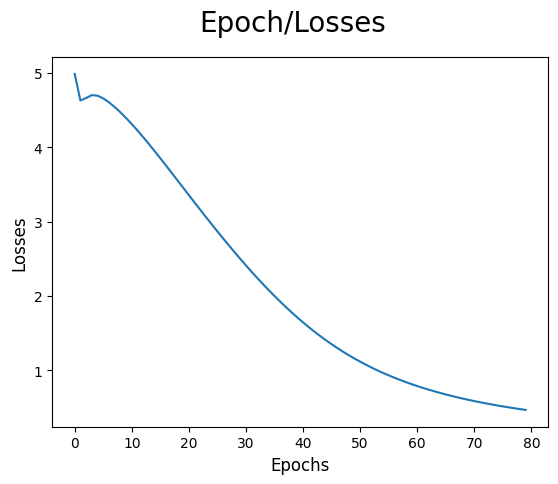

In [41]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [42]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [47]:



predict(['are', 'about', 'study', 'the'])

'to'

In [46]:
predict(['we', 'are', 'to', 'study'])
# (['we', 'are', 'to', 'study'], 'about')

'about'

Accuracy

In [22]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [23]:
accuracy()

1.0

In [24]:
predict(['processes', 'manipulate', 'things', 'study'])

'other'